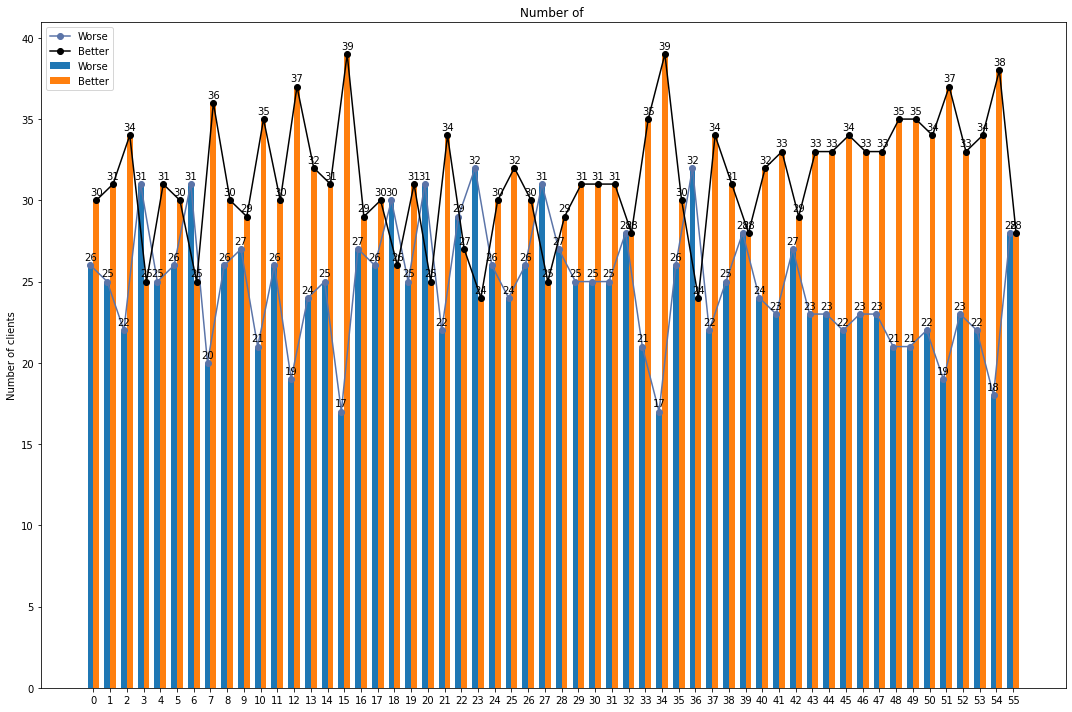

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


worse_clients = [26, 25, 22, 31, 25, 26, 31, 20, 26, 27, 21, 26, 19, 24, 25, 17, 27, 26, 30, 25, 31, 22, 29, 32, 26, 24, 26, 31, 27, 25, 25, 25, 28, 21, 17, 26, 32, 22, 25, 28, 24, 23, 27, 23, 23, 22, 23, 23, 21, 21, 22, 19, 23, 22, 18, 28]
better_clients = [30, 31, 34, 25, 31, 30, 25, 36, 30, 29, 35, 30, 37, 32, 31, 39, 29, 30, 26, 31, 25, 34, 27, 24, 30, 32, 30, 25, 29, 31, 31, 31, 28, 35, 39, 30, 24, 34, 31, 28, 32, 33, 29, 33, 33, 34, 33, 33, 35, 35, 34, 37, 33, 34, 38, 28]
labels = range(0, np.size(better_clients))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=[15,10])
rects1 = ax.bar(x - width/2, worse_clients, width, label='Worse')
rects2 = ax.bar(x + width/2, better_clients, width, label='Better')

trend_line = plt.plot(x - width/2, worse_clients,marker='o', color='#5b74a8', label='Worse')
trend_line = plt.plot(x + width/2, better_clients,marker='o', color='black', label='Better')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of clients')
ax.set_title('Number of ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
plt.savefig('plots/improvement.png')

In [18]:
import os
import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns

sns.color_palette("Spectral", as_cmap=True)

def train_single_model(file_name):
    path = 'data'
    file_name = file_name
    file = os.path.join(path, file_name)
    print(file)
    # read data
    df = pd.read_csv(file)
    feature_names = ['Age','Tenure','PSYTE_Segment','Total_score','Trnx_count','num_products', 'Churn_risk']
    #feature_names = ['Age','Tenure','PSYTE_Segment','Trnx_count','num_products', 'Churn_risk']

    selected_df = df[feature_names].dropna()

    # binarize
    selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'  
    #selected_df = selected_df.drop(selected_df[selected_df['Churn_risk'] == 'Medium'].index) 
    

    selected_df['Churn_risk'] = selected_df.Churn_risk.astype("category").cat.codes
    client_data = selected_df.dropna()

    #for rat in range(100,1,-1):
    #data_s = data.sample(frac=0.01)
    #data_r = data_s.sample(frac=rat/100.)
    client_data = client_data.sample(frac=0.01)
    X = client_data.drop(columns=['Churn_risk','PSYTE_Segment'])
    y = client_data['Churn_risk']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 
    
    X = pd.concat([X_train, y_train], axis=1)
    low = X[X.Churn_risk==1]
    high = X[X.Churn_risk==0]
    #medium = X[X.Churn_risk==2]
    
    X.Churn_risk.value_counts()

    low_downsampled = resample(low,
                                replace = True, # sample without replacement
                                n_samples = len(high), # match minority n
                                random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([low_downsampled, high])

    # checking counts
    print('Labels counts after balancing.')
    print(downsampled.Churn_risk.value_counts())

    X_train = downsampled.drop('Churn_risk', axis=1)
    y_train = downsampled.Churn_risk
    
    print(f'Traing size {np.shape(y_train)}')
    print(f'Testing size {np.shape(y_test)}')


    
    LR = LogisticRegressionCV()
    LRparam_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
         'max_iter': list(range(100,800,100)),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

    # fitting the model for grid search 
    LR_search.fit(X_train , y_train)
    LR_search.best_params_
    # summarize
    print('Mean Accuracy: %.3f' % LR_search.best_score_)
    print('Config: %s' % LR_search.best_params_)



    #clf = LogisticRegressionCV( cv=10, max_iter=100, tol=1e-2, n_jobs=-1, solver='liblinear', scoring='f1')
    clf = LogisticRegressionCV( cv=10, max_iter=100000, tol=1e-6, n_jobs=-1, solver='lbfgs')

    clf.fit(X_train, y_train)
    
    print(clf.predict_proba(X_train)[:,1])
    
    #spit the test data into 2 set
    X_combined = pd.concat([X_test, y_test], axis=1)
    X_test_b = np.array_split(X_combined.sample(frac=1), 10)
    #a = pd.DataFrame(X_test_b[0])

    # train    
    y_pred3=clf.predict(X_train)
    f12 = round(np.max(f1_score(y_train, y_pred3, average=None))*100, 2)
    print(f'The performance of the model: {np.round(clf.score(X_test, y_test)*100,2)}')

    # folding
    #spit the test data into 2 set
    X_combined = pd.concat([X_test, y_test], axis=1)
    X_test_b = np.array_split(X_combined.sample(frac=1), 10)

    for k, test in enumerate(X_test_b):
        y_pred_1=clf.predict(test.drop(columns='Churn_risk'))
        f1 = round(np.max(f1_score(test['Churn_risk'], y_pred_1, average=None))*100, 2)
        print(f'f1 for {k}th-fold test data', f1)

    '''
    #f1_ave = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
    #accuracy = round(accuracy_score(y_test, y_pred)*100,2)
    report1 = classification_report(X_test_b[0]['Churn_risk'], y_pred_1, zero_division=0)
    print(report1)
    report2 = classification_report(X_test_b[1]['Churn_risk'], y_pred_2, zero_division=0)
    print(report2)
    
    print(classification_report(y_train, y_pred3, zero_division=0))
    print(confusion_matrix(X_test_b[0]['Churn_risk'], y_pred_1))
    print(confusion_matrix(X_test_b[1]['Churn_risk'], y_pred_2))
    print('f1 for test 1 data', f1)
    print('f1 for test 2 data', f2)
    print('f1 for train data', f12)

    '''
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 14))
    idx_feature = 0  

    _X = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns='index')
    print(np.shape(_X))
    for i in range(ax.shape[0]):
        for j in range(0, ax.shape[1]):
            try:  
                feature = _X.columns[idx_feature]    
                plot = sns.histplot(_X, 
                                hue = 'Churn_risk', 
                                x = feature, 
                                multiple = 'stack',
                                binwidth = 1,
                                bins=5,
                                stat = 'count',
                                ax=ax[i][j])
                #plt.show()
                idx_feature +=1
            except IndexError:
                pass
            plt.savefig(f'feature_distribution_train.png')

    _Y = pd.concat([X_test, y_test], axis=1).reset_index().drop(columns='index')

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 14))
    idx_feature = 0  
    for i in range(ax.shape[0]):
        for j in range(0, ax.shape[1]):
            try:  
                feature = _Y.columns[idx_feature]    
                plot = sns.histplot(_Y, 
                                hue = 'Churn_risk', 
                                x = feature, 
                                multiple = 'stack',
                                binwidth = 1,
                                bins=5,
                                stat = 'count',
                                ax=ax[i][j])
                #plt.show()
                idx_feature +=1
            except IndexError:
                pass
            plt.savefig(f'feature_distribution_test.png')
            
train_single_model('churnsimulateddata.csv')

data/churnsimulateddata.csv


FileNotFoundError: [Errno 2] No such file or directory: 'data/churnsimulateddata.csv'

../data/churnsimulateddata.csv
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_2621/3029861424.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 1
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_2621/3029861424.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 2
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_2621/3029861424.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

(424015, 7)


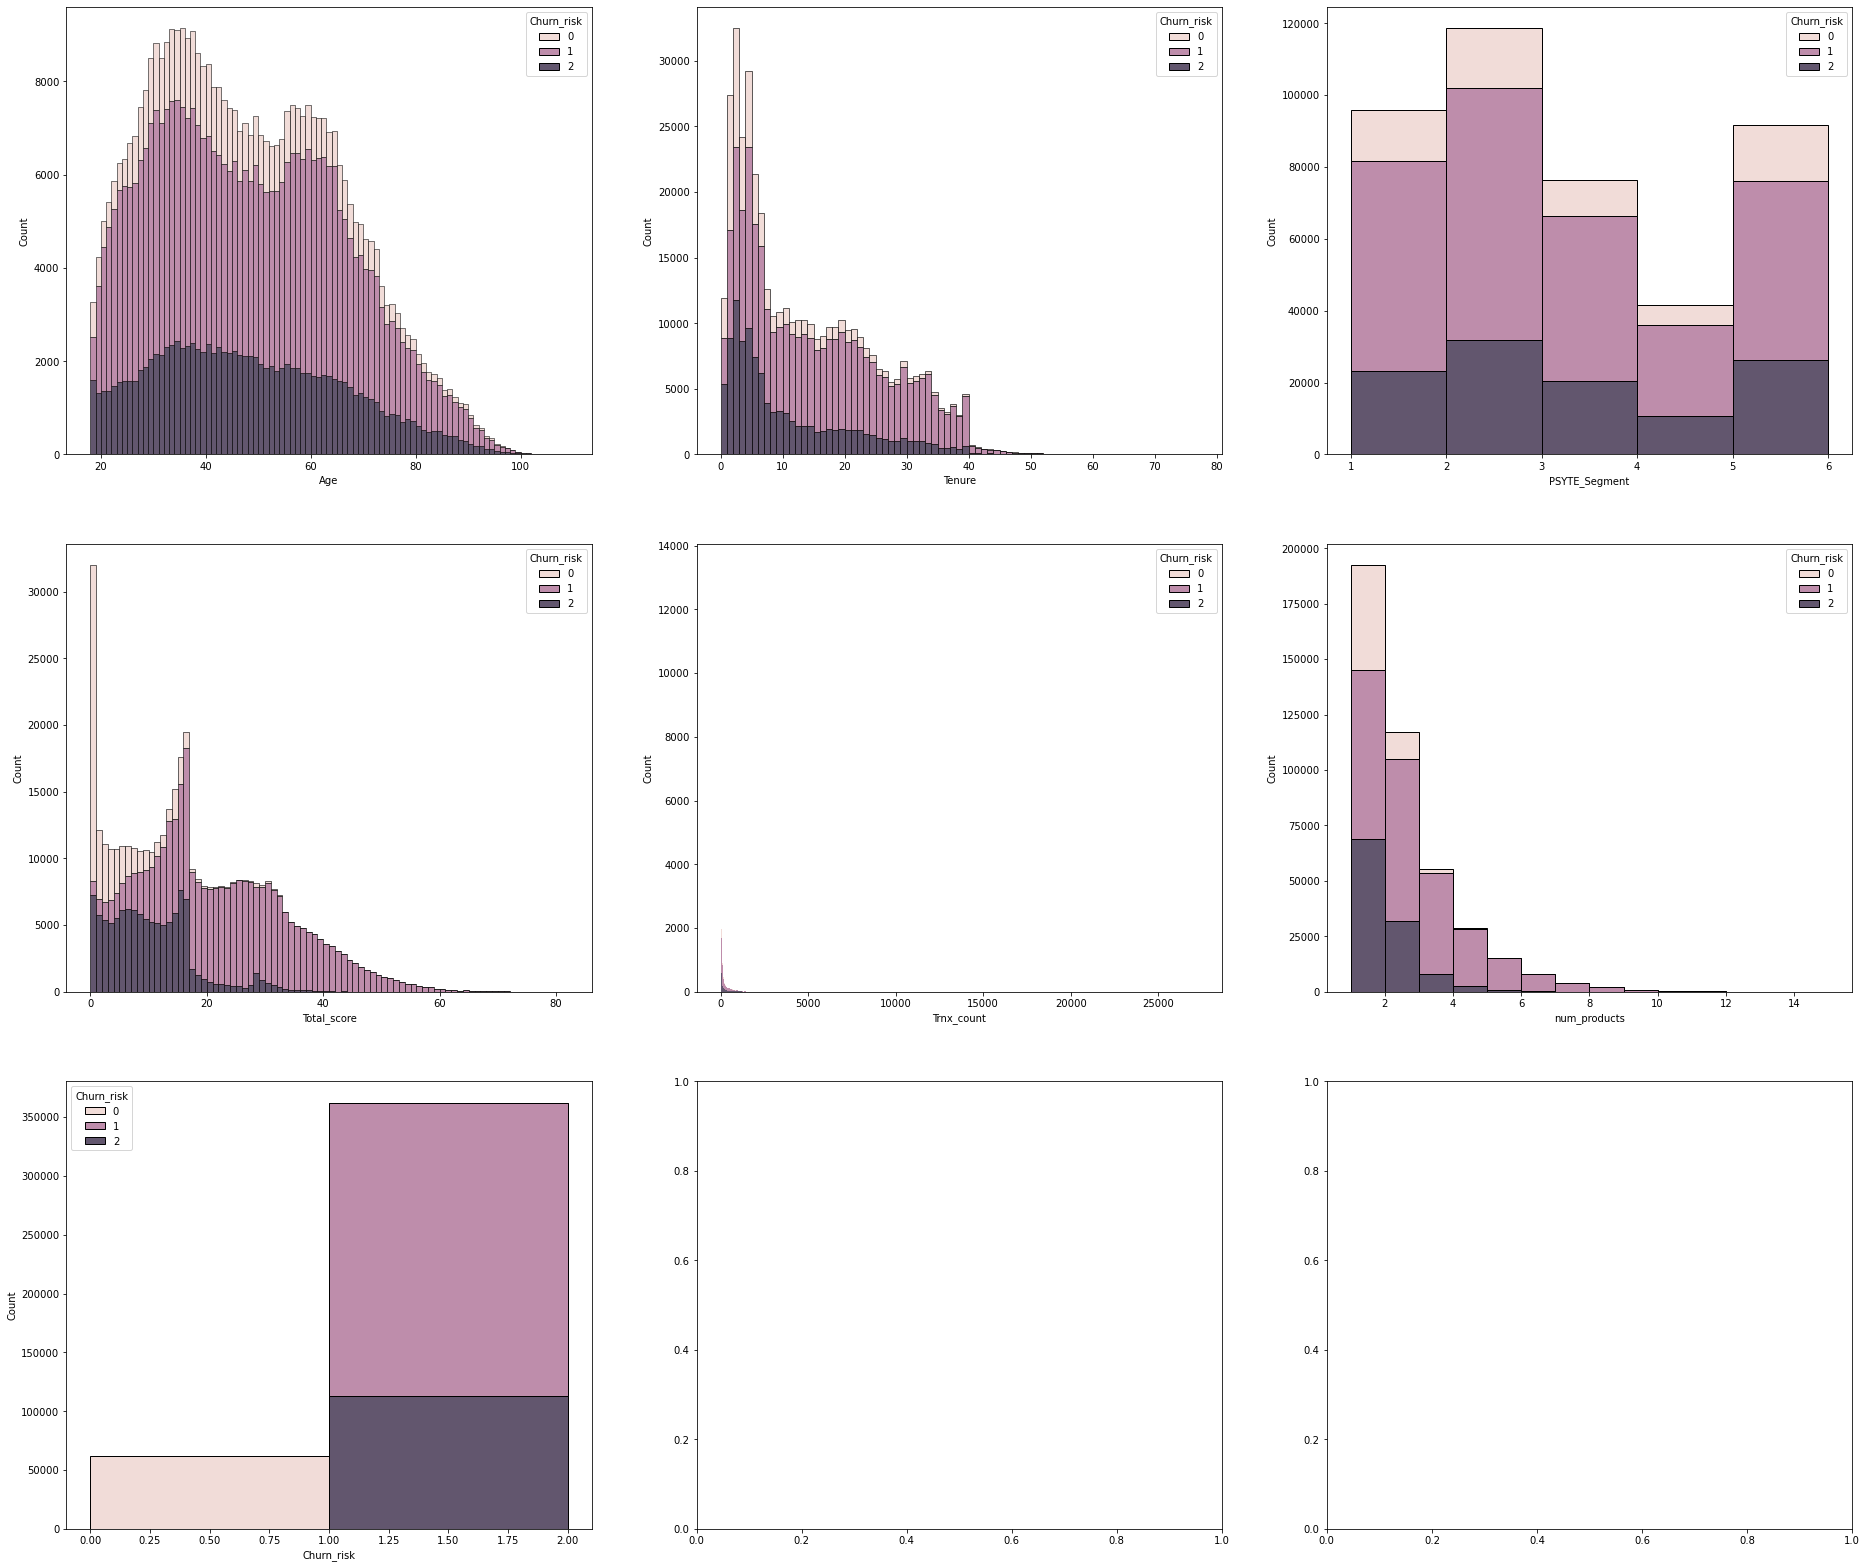

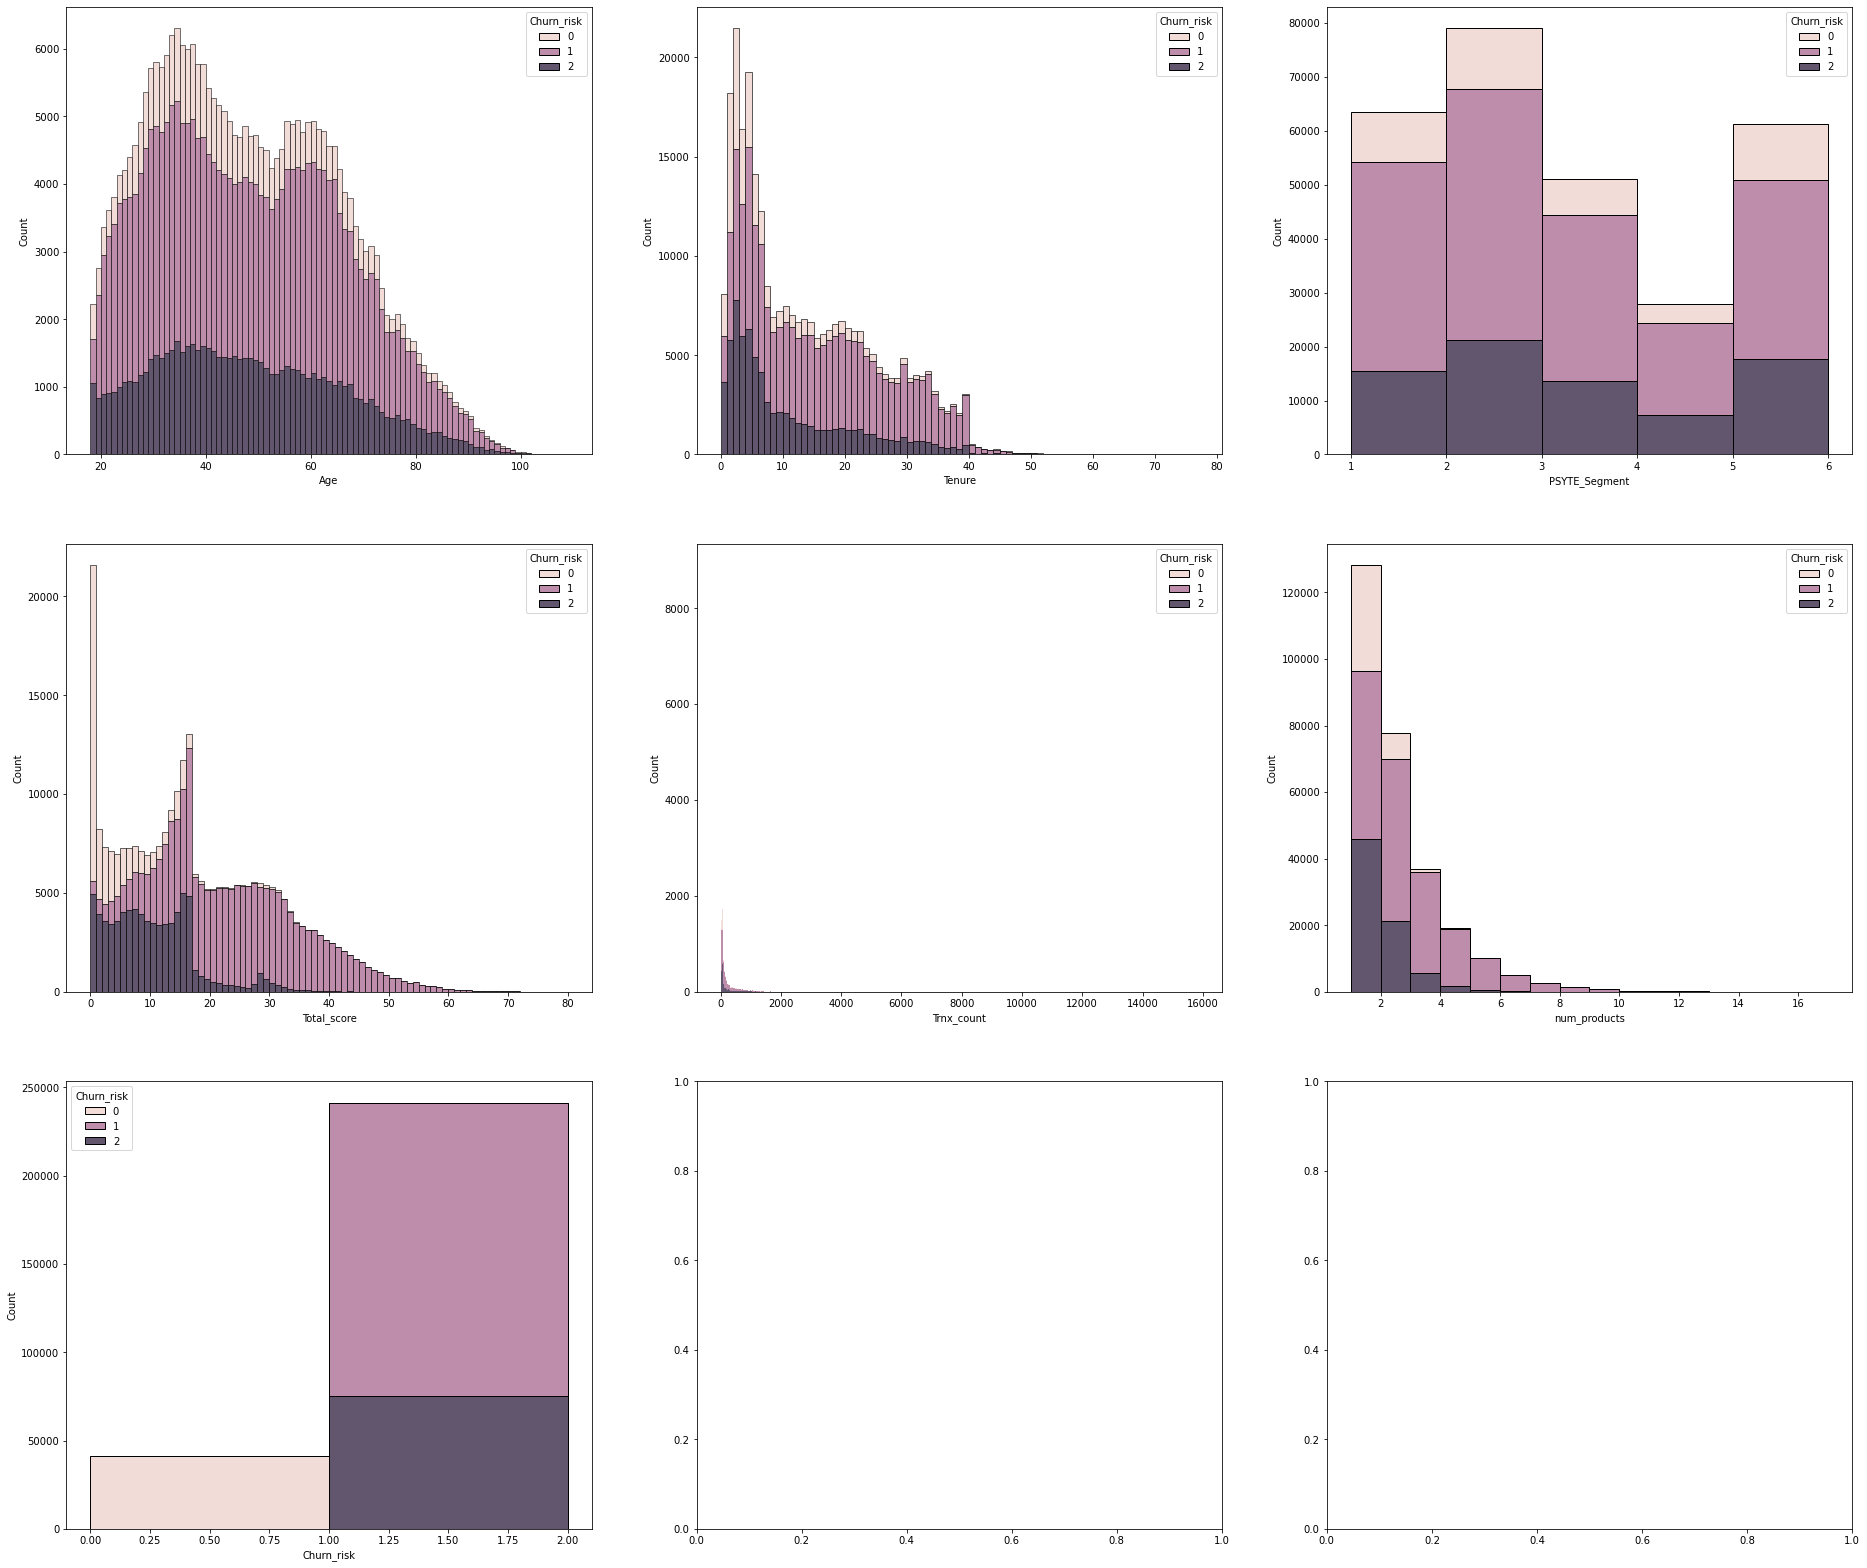

In [22]:
import os
import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns


sns.color_palette("Spectral", as_cmap=True)

path = 'data'
file = '../data/churnsimulateddata.csv'
#file = os.path.join(path, file_name)
print(file)
# read data
df = pd.read_csv(file)
feature_names = ['Age','Tenure','PSYTE_Segment','Total_score','Trnx_count','num_products', 'Churn_risk']
#feature_names = ['Age','Tenure','PSYTE_Segment','Trnx_count','num_products', 'Churn_risk']

selected_df = df[feature_names].dropna()

# binarize
#selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'  
#selected_df = selected_df.drop(selected_df[selected_df['Churn_risk'] == 'Medium'].index) 


# siztiemze the geolocations, make only 6 geolocation

for i in range(1,10,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 1  
for i in range(10,19,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 2  
for i in range(19,28,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 3  
for i in range(28,37,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 4  
for i in range(37,46,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 5  
for i in range(46,58,1):
    print(i)
    selected_df['PSYTE_Segment'][selected_df['PSYTE_Segment'] == i] = 6  




selected_df['Churn_risk'] = selected_df.Churn_risk.astype("category").cat.codes
client_data = selected_df.dropna()

#for rat in range(100,1,-1):
#data_s = data.sample(frac=0.01)
#data_r = data_s.sample(frac=rat/100.)
client_data = client_data.sample(frac=1)
X = client_data.drop(columns=['Churn_risk'])
y = client_data['Churn_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 

X = pd.concat([X_train, y_train], axis=1)
low = X[X.Churn_risk==1]
high = X[X.Churn_risk==0]
#medium = X[X.Churn_risk==2]

X.Churn_risk.value_counts()


    

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(32, 28))
idx_feature = 0  

_X = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns='index')
print(np.shape(_X))
for i in range(ax.shape[0]):
    for j in range(0, ax.shape[1]):
        try:  
            feature = _X.columns[idx_feature]    
            plot = sns.histplot(_X, 
                            hue = 'Churn_risk', 
                            x = feature, 
                            multiple = 'stack',
                            binwidth = 1,
                            bins=6,
                            stat = 'count',
                            ax=ax[i][j])
            #plt.show()
            idx_feature +=1
        except IndexError:
            pass
        plt.savefig(f'feature_distribution_train.png')

_Y = pd.concat([X_test, y_test], axis=1).reset_index().drop(columns='index')

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(32, 28))
idx_feature = 0  
for i in range(ax.shape[0]):
    for j in range(0, ax.shape[1]):
        try:  
            feature = _Y.columns[idx_feature]    
            plot = sns.histplot(_Y, 
                            hue = 'Churn_risk', 
                            x = feature, 
                            multiple = 'stack',
                            binwidth = 1,
                            bins=5,
                            stat = 'count',
                            ax=ax[i][j])
            #plt.show()
            idx_feature +=1
        except IndexError:
            pass
        plt.savefig(f'feature_distribution_test.png')

